In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm 
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

In [2]:
from sklearn.ensemble import RandomForestRegressor

Load the mass of each alcohol and its respective FOM in mixture

In [3]:
#X -> mass of each component ['methanol', 'butanol', 'acetone']; total_mass = 1000
#y -> FOM(density, viscosity, thermal cond, specific heat capacity)
X, y = np.load("mass_batch.npy"), np.load("res_v.npy")

#X shape : (5151, 3)
#y shape : (5151,)

Generate initial experiments (initial mass fractions):
1. Pure components: {[1, 0, 0], [0, 1, 0], [0, 0, 1]}
2. Do 1/2-1/2: {[0.5, 0.5, 0], [0, 0.5, 0.5], [0.5, 0, 0.5]}
3. Do 1/3 of each comp: {[1/3, 1/3, 1/3]}

In [4]:
total_mass = 100
X_norm = np.array([np.divide(i, total_mass) for i in X]) #converts to mass fractions of each component

In [31]:
random_arrays = np.array([[0.65, 0.21, 0.14],
                        [0.62, 0.03, 0.35],
                        [0.58, 0.18, 0.24]])

In [24]:
# Number of arrays to randomly sample
num_arrays_to_sample = 3  # You can adjust this as needed

# Randomly choose one or more arrays from the nested array
random_arrays_indices = np.random.choice(X_norm.shape[0], size=num_arrays_to_sample, replace=False)
random_arrays = X_norm[random_arrays_indices]

# Print the result
print(f"Randomly chosen {num_arrays_to_sample} array(s):")
print(random_arrays)

Randomly chosen 3 array(s):
[[0.08 0.48 0.44]
 [0.46 0.13 0.41]
 [0.35 0.37 0.28]]


In [32]:
#initial_X = np.array([[0.8, 0, 0.2], [0.2, 0.8, 0], [0, 0.2, 0.8],
#                    [0.5, 0.5, 0], [0, 0.5, 0.5], [0.5, 0, 0.5]
#                    ])

#initial_X = initial_X * total_mass
initial_X = random_arrays

initial_y = []
for i in initial_X:
    indice = np.where(np.all(X_norm == i, axis=1))[0][0]
    initial_y.append(y[indice])

initial_y = np.array(initial_y)

In [33]:
#model.fit(initial_X, initial_y)

#Create RandomForest model
model = RandomForestRegressor(max_depth=2, random_state=0)

In [34]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current maxima
    current_objective = y_pred[np.argmax(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    #pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)
    
    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI

In [35]:
#iterate 5 times and see results change

n_iterations = 5
y_pred_arr, EI_arr = [], []

for c in range(n_iterations):
    print('-----------------------------------------------')
    print("Iteration : {}".format(c))
    model.fit(initial_X, initial_y)
    #y_pred, pred_std = model.predict(X_norm, return_std=True)
    y_pred = model.predict(X_norm)
    pred_std = np.std(y_pred)
    y_pred_arr.append(y_pred)
    
    pred_std = pred_std.flatten()

    index = np.argmax(y_pred)
    current_location = X_norm[index]
    current_objective = y_pred[index]
    print("Current location : {}".format(current_location))
    print("Current objective value : {}".format(current_objective))
    print("Targeted objective value : {}".format(y[np.argmax(y)]))

    new_sample, EI_new = EI_learning(X_norm, y_pred, pred_std)
    EI_arr.append(EI_new)
    print("Next best data point : {}".format(new_sample))

    initial_X = np.vstack([initial_X, new_sample])
    initial_y = []

    for i in initial_X:
        indice = np.where(np.all(X_norm == i, axis = 1))[0][0]
        initial_y.append(y[indice])
    
    initial_y = np.array(initial_y)

-----------------------------------------------
Iteration : 0
Current location : [0.   0.81 0.19]
Current objective value : 4.683611030489035
Targeted objective value : 7.550369650888264
Next best data point : [0.6 0.  0.4]
-----------------------------------------------
Iteration : 1
Current location : [0.64 0.2  0.16]
Current objective value : 4.661082952751285
Targeted objective value : 7.550369650888264
Next best data point : [0.6 0.  0.4]
-----------------------------------------------
Iteration : 2
Current location : [0.64 0.2  0.16]
Current objective value : 4.644984949080872
Targeted objective value : 7.550369650888264
Next best data point : [0.6 0.  0.4]
-----------------------------------------------
Iteration : 3
Current location : [0.64 0.2  0.16]
Current objective value : 4.647886177639601
Targeted objective value : 7.550369650888264
Next best data point : [0.6 0.  0.4]
-----------------------------------------------
Iteration : 4
Current location : [0.   0.81 0.19]
Curren

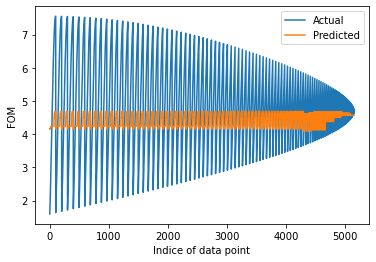

In [36]:
plt.plot(y)
plt.plot(y_pred_arr[0])
plt.xlabel('Indice of data point')
plt.ylabel('FOM')
plt.legend(['Actual', 'Predicted'])

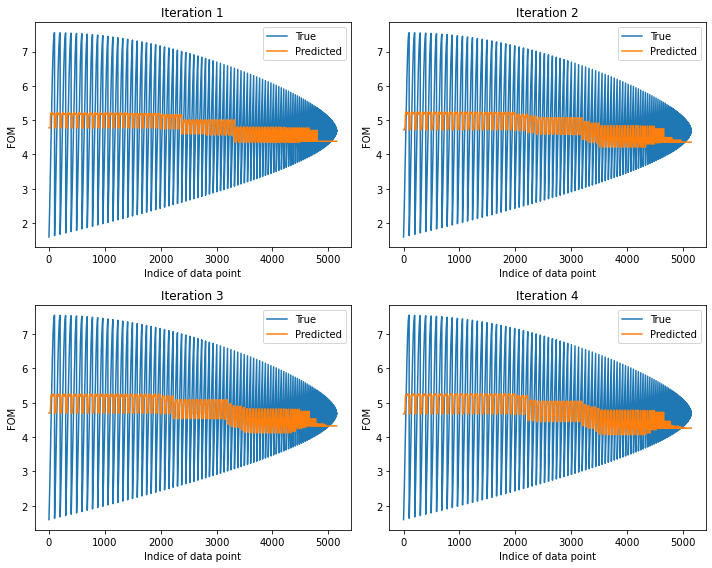

In [30]:
plt.figure(figsize=(10, 8))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.plot(y)
    plt.plot(y_pred_arr[i-1])
    plt.xlabel('Indice of data point')
    plt.ylabel('FOM')
    plt.legend(['True', 'Predicted'], loc = 'upper right') #commented out because legend takes a lot of space
    plt.title('Iteration {}'.format(i))

plt.tight_layout()
plt.show()